In [1]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

Constants

In [2]:
img_width = 32

In [3]:
eps, beta = 0.1, 4

Load CIFAR10 Dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


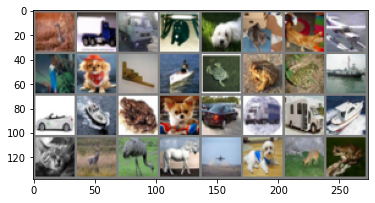

bird  truck truck cat   dog   cat   cat   plane bird  dog   plane ship  frog  frog  frog  ship  car   ship  frog  dog   car   truck truck ship  cat   deer  bird  horse plane dog   deer  frog 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if train_on_gpu else 'cpu')

CUDA is available!  Training on GPU ...


In [7]:
def train(epoch):

  model.train()
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      
      inputs, labels = inputs.to(device), labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, i * len(data), len(trainloader.dataset),
            100. * i / len(trainloader), running_loss))

def test():
  correct = 0
  total = 0
  test_loss = 0
  model.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data

          images, labels = images.to(device), labels.to(device)

          # calculate outputs by running images through the network
          outputs = model(images)

          test_loss += criterion(outputs, labels).data
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

ReLU

In [20]:
class Conv4Relu(nn.Module):

    def __init__(self):
    
      super(Conv4Relu, self).__init__()
      self.C1 = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 'same')
      self.C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
      self.C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
      self.C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

      self.flatten = nn.Flatten()
      self.D1 = nn.Linear(32*32*128, 256)
      self.D2 = nn.Linear(256, 256)

      #Output
      self.outputs = nn.Linear(256, 10)

    def forward(self, x):

      R = F.relu(self.C1(x))
      R = F.relu(self.C2(R))
      R = F.relu(self.C3(R))
      R = F.relu(self.C4(R))

      R = self.flatten(R)

      R = F.relu(self.D1(R))
      R = F.relu(self.D2(R))

      return self.outputs(R)

In [ ]:
model = Conv4Relu()
model.to(device)
model

Conv4Relu(
  (C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (D1): Linear(in_features=131072, out_features=256, bias=True)
  (D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 3066.177735

Test set: Average loss: 510.6411, Accuracy: 4101/10000 (41%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2390.412157

Test set: Average loss: 454.9616, Accuracy: 4756/10000 (48%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 2120.666588

Test set: Average loss: 420.6679, Accuracy: 5155/10000 (52%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 1912.311433

Test set: Average loss: 390.8379, Accuracy: 5560/10000 (56%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 1725.597467

Test set: Average loss: 377.2816, Accuracy: 5723/10000 (57%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 1542.315742

Test set: Average loss: 341.9350, Accuracy: 6120/10000 (61%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 1345.632795

Test set: Average loss: 361.8331, Accuracy: 6015/10000 (60%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 1127.646560

Test set: Average loss: 367.3432, Accuracy: 6055/10000 (61%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 888.322130

Test set: Average l

In [ ]:
class SoftGate(nn.Module):
    def __init__(self, **kwargs):
        super(SoftGate, self).__init__()

    def build(self, input_shape):
        super(SoftGate, self).build(input_shape)  # Be sure to call this at the end

    def forward(self, x):
        activation = (1 + eps)*F.sigmoid(beta*x)
        return activation

    def compute_output_shape(self, input_shape):
        return input_shape

Decoupled learning with Soft ReLU activation

In [ ]:
class DecoupledLearning(nn.Module):

  def __init__(self):
      
      super(DecoupledLearning, self).__init__()

      self.C1 = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 'same')
      self.C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
      self.C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
      self.C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

      self.F1 = nn.Flatten()
      self.D1 = nn.Linear(32*32*128, 256)
      self.D2 = nn.Linear(256, 256)

      #V2
      self.C1_G = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 'same')
      self.C2_G = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
      self.C3_G = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
      self.C4_G = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
      self.F1_G = nn.Flatten()
      self.D1_G = nn.Linear(32*32*128, 256)
      self.D2_G = nn.Linear(256, 256)
      self.outputs = nn.Linear(256, 10)

    
  def forward(self, x):

      #V1
      C1 = self.C1(x)
      C1_A = F.relu(C1)
      C2 = self.C2(C1_A)
      C2_A = F.relu(C2)
      C3 = self.C3(C2_A)
      C3_A = F.relu(C3)
      C4 = self.C4(C3_A)
      C4_A = F.relu(C4)

      F1 = self.F1(C4_A)
      D1 = self.D1(F1)
      D1_A = F.relu(D1)
      D2 = self.D2(D1_A)

      A1 = SoftGate()(C1)
      A2 = SoftGate()(C2)
      A3 = SoftGate()(C3)
      A4 = SoftGate()(C4)
      A5 = SoftGate()(D1)
      A6 = SoftGate()(D2)

      #V2
      C1_G = self.C1_G(x)
      C1_G = torch.mul(C1_G, A1)
      C2_G = self.C2_G(C1_G)
      C2_G = torch.mul(C2_G, A2)
      C3_G = self.C3_G(C2_G)
      C3_G = torch.mul(C3_G, A3)
      C4_G = self.C4_G(C3_G)
      C4_G = torch.mul(C4_G, A4)

      F1_G = self.F1_G(C4_G)
      D1_G = self.D1_G(F1_G)
      D1_G = torch.mul(D1_G, A5)
      D2_G = self.D2_G(D1_G)
      D2_G = torch.mul(D2_G, A6)

      return self.outputs(D2_G)

In [ ]:
model = DecoupledLearning()
model.to(device)
model

DecoupledLearning(
  (C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (F1): Flatten(start_dim=1, end_dim=-1)
  (D1): Linear(in_features=131072, out_features=256, bias=True)
  (D2): Linear(in_features=256, out_features=256, bias=True)
  (C1_G): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C2_G): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C3_G): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C4_G): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (F1_G): Flatten(start_dim=1, end_dim=-1)
  (D1_G): Linear(in_features=131072, out_features=256, bias=True)
  (D2_G): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256, out_features=10, b

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
for epoch in range(1, 81):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [3124/50000 (100%)]	Loss: 3463.589293

Test set: Average loss: 606.6343, Accuracy: 3286/10000 (33%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2655.470029

Test set: Average loss: 485.9721, Accuracy: 4453/10000 (45%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 2243.734135

Test set: Average loss: 422.9943, Accuracy: 5213/10000 (52%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 2010.825334

Test set: Average loss: 397.8923, Accuracy: 5477/10000 (55%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 1813.163920

Test set: Average loss: 379.4728, Accuracy: 5776/10000 (58%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 1619.147882

Test set: Average loss: 353.9225, Accuracy: 6007/10000 (60%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 1395.563984

Test set: Average loss: 351.5441, Accuracy: 6142/10000 (61%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 1140.208155

Test set: Average loss: 357.5344, Accuracy: 6264/10000 (63%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 835.329778

Test set: Average l

DGN

In [8]:
class SignGate(nn.Module):
    def __init__(self, **kwargs):
        super(SignGate, self).__init__()

    def build(self, input_shape):
        super(SignGate, self).build(input_shape)  # Be sure to call this at the end

    def forward(self, x):
        output = torch.sign(F.relu(x))
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
class Conv4Galu(nn.Module):

  def __init__(self):
    
    super(Conv4Galu, self).__init__()

    #V1
    self.N1_C1 = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 'same')
    self.N1_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.N1_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.N1_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.N1_F1 = nn.Flatten()
    self.N1_D1 = nn.Linear(32*32*128, 256)
    self.N1_D2 = nn.Linear(256, 256)


    #V2
    self.N2_C1 = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 'same')
    self.N2_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.N2_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.N2_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    
    self.N2_F1 = nn.Flatten()
    self.N2_D1 = nn.Linear(32*32*128, 256)
    self.N2_D2 = nn.Linear(256, 256)

    self.outputs = nn.Linear(256, 10)

  def forward(self, x):

    #V1
    C1 = F.relu(self.N1_C1(x))
    C2 = F.relu(self.N1_C2(C1))
    C3 = F.relu(self.N1_C3(C2))
    C4 = F.relu(self.N1_C4(C3))

    F1 = self.N1_F1(C4)
    D1 = F.relu(self.N1_D1(F1))
    D2 = F.relu(self.N1_D2(D1))

    
    A1 = SignGate()(C1)
    A2 = SignGate()(C2)
    A3 = SignGate()(C3)
    A4 = SignGate()(C4)
    A5 = SignGate()(D1)
    A6 = SignGate()(D2)

    #V2
    C1_G = self.N2_C1(x)
    C1_G = torch.mul(C1_G, A1)
    C2_G = self.N2_C2(C1_G)
    C2_G = torch.mul(C2_G, A2)
    C3_G = self.N2_C3(C2_G)
    C3_G = torch.mul(C3_G, A3)
    C4_G = self.N2_C4(C3_G)
    C4_G = torch.mul(C4_G, A4)

    F1_G = self.N2_F1(C4_G)
    D1_G = self.N2_D1(F1_G)
    D1_G = torch.mul(D1_G, A5)
    D2_G = self.N2_D2(D1_G)
    D2_G = torch.mul(D2_G, A6)

    return self.outputs(D2_G)

Decoupled Learning with hard relu

In [ ]:
model = Conv4Galu()
model.to(device)
model

Conv4Galu(
  (N1_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_F1): Flatten(start_dim=1, end_dim=-1)
  (N1_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N1_D2): Linear(in_features=256, out_features=256, bias=True)
  (N2_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_F1): Flatten(start_dim=1, end_dim=-1)
  (N2_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N2_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 3008.702818

Test set: Average loss: 509.3687, Accuracy: 4262/10000 (43%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2168.051513

Test set: Average loss: 409.9548, Accuracy: 5317/10000 (53%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 1779.211344

Test set: Average loss: 379.4973, Accuracy: 5719/10000 (57%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 1400.781019

Test set: Average loss: 394.4732, Accuracy: 5737/10000 (57%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 917.882225

Test set: Average loss: 445.9763, Accuracy: 5646/10000 (56%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 456.357554

Test set: Average loss: 580.4485, Accuracy: 5656/10000 (57%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 222.678165

Test set: Average loss: 674.3165, Accuracy: 5677/10000 (57%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 126.785095

Test set: Average loss: 786.9297, Accuracy: 5640/10000 (56%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 99.793630

Test set: Average loss: 

FRNPF(II)

In [ ]:
model = Conv4Galu()
model.to(device)
model

Conv4Galu(
  (N1_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_F1): Flatten(start_dim=1, end_dim=-1)
  (N1_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N1_D2): Linear(in_features=256, out_features=256, bias=True)
  (N2_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_F1): Flatten(start_dim=1, end_dim=-1)
  (N2_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N2_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256

In [ ]:
for name, param in model.named_parameters():
    if name[0:2]=='N1':
        param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

N2_C1.weight
N2_C1.bias
N2_C2.weight
N2_C2.bias
N2_C3.weight
N2_C3.bias
N2_C4.weight
N2_C4.bias
N2_D1.weight
N2_D1.bias
N2_D2.weight
N2_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 2978.537833

Test set: Average loss: 476.8409, Accuracy: 4492/10000 (45%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2162.187945

Test set: Average loss: 410.8533, Accuracy: 5284/10000 (53%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 1805.238190

Test set: Average loss: 409.1857, Accuracy: 5475/10000 (55%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 1448.303231

Test set: Average loss: 402.5682, Accuracy: 5575/10000 (56%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 989.863473

Test set: Average loss: 481.5861, Accuracy: 5334/10000 (53%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 513.677821

Test set: Average loss: 560.6436, Accuracy: 5451/10000 (55%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 248.603340

Test set: Average loss: 723.5992, Accuracy: 5486/10000 (55%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 143.641600

Test set: Average loss: 830.1932, Accuracy: 5487/10000 (55%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 91.248585

Test set: Average loss: 

FRNPF(DI)

In [10]:
model = Conv4Galu()
model.to(device)
model

Conv4Galu(
  (N1_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_F1): Flatten(start_dim=1, end_dim=-1)
  (N1_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N1_D2): Linear(in_features=256, out_features=256, bias=True)
  (N2_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_F1): Flatten(start_dim=1, end_dim=-1)
  (N2_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N2_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256

In [13]:
for name, param in model.named_parameters():
  print(name, param)

N1_C1.weight Parameter containing:
tensor([[[[-1.5751e-02,  1.8377e-01,  1.5067e-01],
          [-5.2458e-02, -1.8347e-01,  1.5553e-01],
          [ 8.5427e-02,  8.4333e-03, -1.1791e-01]],

         [[ 9.3870e-02,  1.5532e-01,  1.0040e-01],
          [-5.4865e-02,  7.3119e-02, -1.5564e-01],
          [-8.2653e-02, -1.4993e-01, -1.4855e-01]],

         [[-1.7436e-01, -3.4497e-02, -2.8740e-02],
          [-1.0539e-01,  5.4372e-02, -9.3557e-02],
          [-2.3659e-02,  1.7833e-01, -5.9122e-02]]],


        [[[ 5.8111e-02,  1.2392e-01, -1.5378e-01],
          [-9.8643e-03,  1.6460e-01,  4.6094e-02],
          [-4.1165e-02, -7.9933e-02,  1.2361e-01]],

         [[-9.4299e-02, -5.6796e-02, -9.6843e-02],
          [ 1.5443e-01,  1.0551e-01, -1.2970e-01],
          [-6.8913e-02, -1.8086e-01,  3.8319e-02]],

         [[ 2.3538e-02,  1.7668e-01,  1.6701e-01],
          [-8.1817e-02, -1.8101e-02, -1.2344e-01],
          [ 3.7531e-02,  1.3823e-01,  8.9921e-02]]],


        [[[ 1.8629e-01,  1.0086

In [14]:
model.state_dict().get("N1_C1.weight").data

tensor([[[[-1.5751e-02,  1.8377e-01,  1.5067e-01],
          [-5.2458e-02, -1.8347e-01,  1.5553e-01],
          [ 8.5427e-02,  8.4333e-03, -1.1791e-01]],

         [[ 9.3870e-02,  1.5532e-01,  1.0040e-01],
          [-5.4865e-02,  7.3119e-02, -1.5564e-01],
          [-8.2653e-02, -1.4993e-01, -1.4855e-01]],

         [[-1.7436e-01, -3.4497e-02, -2.8740e-02],
          [-1.0539e-01,  5.4372e-02, -9.3557e-02],
          [-2.3659e-02,  1.7833e-01, -5.9122e-02]]],


        [[[ 5.8111e-02,  1.2392e-01, -1.5378e-01],
          [-9.8643e-03,  1.6460e-01,  4.6094e-02],
          [-4.1165e-02, -7.9933e-02,  1.2361e-01]],

         [[-9.4299e-02, -5.6796e-02, -9.6843e-02],
          [ 1.5443e-01,  1.0551e-01, -1.2970e-01],
          [-6.8913e-02, -1.8086e-01,  3.8319e-02]],

         [[ 2.3538e-02,  1.7668e-01,  1.6701e-01],
          [-8.1817e-02, -1.8101e-02, -1.2344e-01],
          [ 3.7531e-02,  1.3823e-01,  8.9921e-02]]],


        [[[ 1.8629e-01,  1.0086e-02,  1.5948e-02],
          [-5.4

In [15]:
for name, param in model.named_parameters():
    if name[0:2]=='N1':
      paramName = "N2"+name[2:]
      param.data = model.state_dict().get(paramName).data
      param.requires_grad = False
    print(name, param)

N1_C1.weight Parameter containing:
tensor([[[[ 0.1655, -0.1023, -0.0654],
          [ 0.1320,  0.1459, -0.0293],
          [ 0.1307, -0.0038, -0.1443]],

         [[ 0.1255, -0.1350,  0.0066],
          [-0.0885,  0.1231, -0.1065],
          [-0.0700, -0.0737,  0.1228]],

         [[ 0.1619,  0.1924,  0.1041],
          [ 0.1877,  0.1497,  0.0791],
          [-0.0548,  0.0440, -0.0788]]],


        [[[-0.1344, -0.0201,  0.0196],
          [-0.0519,  0.0757, -0.0161],
          [-0.1060, -0.0630, -0.0215]],

         [[ 0.0048, -0.1831,  0.1577],
          [-0.1467,  0.1101,  0.1224],
          [-0.0428,  0.1472, -0.1545]],

         [[ 0.1256,  0.1142,  0.1272],
          [-0.0127, -0.0286,  0.1315],
          [ 0.1065,  0.0171,  0.1037]]],


        [[[ 0.0077, -0.0407, -0.0247],
          [ 0.0596,  0.0894, -0.1481],
          [ 0.1123, -0.1364, -0.1826]],

         [[ 0.0936, -0.0706, -0.1452],
          [ 0.1321, -0.0645,  0.0175],
          [-0.0288,  0.1139,  0.0435]],

         

In [16]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

N2_C1.weight
N2_C1.bias
N2_C2.weight
N2_C2.bias
N2_C3.weight
N2_C3.bias
N2_C4.weight
N2_C4.bias
N2_D1.weight
N2_D1.bias
N2_D2.weight
N2_D2.bias
outputs.weight
outputs.bias


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 3078.861254

Test set: Average loss: 518.1368, Accuracy: 4045/10000 (40%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2395.505561

Test set: Average loss: 443.6495, Accuracy: 4906/10000 (49%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 2107.911940

Test set: Average loss: 403.6222, Accuracy: 5375/10000 (54%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 1888.841750

Test set: Average loss: 370.3296, Accuracy: 5779/10000 (58%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 1687.698318

Test set: Average loss: 353.6449, Accuracy: 5992/10000 (60%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 1492.584705

Test set: Average loss: 345.0158, Accuracy: 5978/10000 (60%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 1303.555784

Test set: Average loss: 315.3890, Accuracy: 6509/10000 (65%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 1106.454641

Test set: Average loss: 340.1308, Accuracy: 6380/10000 (64%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 889.413151

Test set: Average l

FLNPF

In [22]:
model = Conv4Relu()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 3086.428401

Test set: Average loss: 511.7622, Accuracy: 4050/10000 (40%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 2339.563638

Test set: Average loss: 439.9502, Accuracy: 5020/10000 (50%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 2062.114802

Test set: Average loss: 412.6857, Accuracy: 5248/10000 (52%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 1841.932782

Test set: Average loss: 368.9293, Accuracy: 5791/10000 (58%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 1645.002154

Test set: Average loss: 350.4777, Accuracy: 5939/10000 (59%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 1452.582220

Test set: Average loss: 338.5309, Accuracy: 6207/10000 (62%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 1260.276534

Test set: Average loss: 334.2257, Accuracy: 6369/10000 (64%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 1057.363025

Test set: Average loss: 341.2044, Accuracy: 6378/10000 (64%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 838.496314

Test set: Average l

In [23]:
relu_model = model
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[[[ 0.1850,  0.1115,  0.1831],
          [-0.1391,  0.0578,  0.0505],
          [-0.2225,  0.0643,  0.0665]],

         [[ 0.2318,  0.0711,  0.2237],
          [-0.2885, -0.1129, -0.1827],
          [-0.2874, -0.0576,  0.1046]],

         [[ 0.2614,  0.3017,  0.1691],
          [-0.2203, -0.1606, -0.1812],
          [-0.2189, -0.2360,  0.1888]]],


        [[[ 0.2074,  0.0269,  0.1690],
          [ 0.0721, -0.0900,  0.0665],
          [-0.1260, -0.3127, -0.1733]],

         [[-0.1441,  0.2017, -0.0143],
          [ 0.0981,  0.2157,  0.0939],
          [-0.0933, -0.1735,  0.0905]],

         [[-0.2129,  0.0109, -0.1249],
          [ 0.2147,  0.2667,  0.0806],
          [ 0.0045, -0.2233, -0.1043]]],


        [[[ 0.3584,  0.4198,  0.0082],
          [-0.0666, -0.0327, -0.2260],
          [-0.1696, -0.3413,  0.0915]],

         [[ 0.3407,  0.2133,  0.2846],
          [-0.2246, -0.2679, -0.2333],
          [ 0.0398, -0.1506, -0.0129]],

         [[-0.0582,  0

In [24]:
model = Conv4Galu()
model.to(device)
model

Conv4Galu(
  (N1_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N1_F1): Flatten(start_dim=1, end_dim=-1)
  (N1_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N1_D2): Linear(in_features=256, out_features=256, bias=True)
  (N2_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (N2_F1): Flatten(start_dim=1, end_dim=-1)
  (N2_D1): Linear(in_features=131072, out_features=256, bias=True)
  (N2_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256

In [25]:
for p in relu_model.parameters():
  print(p)

Parameter containing:
tensor([[[[ 0.1850,  0.1115,  0.1831],
          [-0.1391,  0.0578,  0.0505],
          [-0.2225,  0.0643,  0.0665]],

         [[ 0.2318,  0.0711,  0.2237],
          [-0.2885, -0.1129, -0.1827],
          [-0.2874, -0.0576,  0.1046]],

         [[ 0.2614,  0.3017,  0.1691],
          [-0.2203, -0.1606, -0.1812],
          [-0.2189, -0.2360,  0.1888]]],


        [[[ 0.2074,  0.0269,  0.1690],
          [ 0.0721, -0.0900,  0.0665],
          [-0.1260, -0.3127, -0.1733]],

         [[-0.1441,  0.2017, -0.0143],
          [ 0.0981,  0.2157,  0.0939],
          [-0.0933, -0.1735,  0.0905]],

         [[-0.2129,  0.0109, -0.1249],
          [ 0.2147,  0.2667,  0.0806],
          [ 0.0045, -0.2233, -0.1043]]],


        [[[ 0.3584,  0.4198,  0.0082],
          [-0.0666, -0.0327, -0.2260],
          [-0.1696, -0.3413,  0.0915]],

         [[ 0.3407,  0.2133,  0.2846],
          [-0.2246, -0.2679, -0.2333],
          [ 0.0398, -0.1506, -0.0129]],

         [[-0.0582,  0

In [26]:
trained_params = [x.data for x in relu_model.parameters()]

i=0
for (name, params) in model.named_parameters():
  if name[0:2]=='N1':
    params.data = trained_params[i]
    params.requires_grad = False
    i+=1
  print(name, params)

N1_C1.weight Parameter containing:
tensor([[[[ 0.1850,  0.1115,  0.1831],
          [-0.1391,  0.0578,  0.0505],
          [-0.2225,  0.0643,  0.0665]],

         [[ 0.2318,  0.0711,  0.2237],
          [-0.2885, -0.1129, -0.1827],
          [-0.2874, -0.0576,  0.1046]],

         [[ 0.2614,  0.3017,  0.1691],
          [-0.2203, -0.1606, -0.1812],
          [-0.2189, -0.2360,  0.1888]]],


        [[[ 0.2074,  0.0269,  0.1690],
          [ 0.0721, -0.0900,  0.0665],
          [-0.1260, -0.3127, -0.1733]],

         [[-0.1441,  0.2017, -0.0143],
          [ 0.0981,  0.2157,  0.0939],
          [-0.0933, -0.1735,  0.0905]],

         [[-0.2129,  0.0109, -0.1249],
          [ 0.2147,  0.2667,  0.0806],
          [ 0.0045, -0.2233, -0.1043]]],


        [[[ 0.3584,  0.4198,  0.0082],
          [-0.0666, -0.0327, -0.2260],
          [-0.1696, -0.3413,  0.0915]],

         [[ 0.3407,  0.2133,  0.2846],
          [-0.2246, -0.2679, -0.2333],
          [ 0.0398, -0.1506, -0.0129]],

         

In [27]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

N2_C1.weight
N2_C1.bias
N2_C2.weight
N2_C2.bias
N2_C3.weight
N2_C3.bias
N2_C4.weight
N2_C4.bias
N2_D1.weight
N2_D1.bias
N2_D2.weight
N2_D2.bias
outputs.weight
outputs.bias


In [28]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
for epoch in range(1, 81):
    train(epoch)
    test()

Train Epoch: 1 [3124/50000 (100%)]	Loss: 2761.240381

Test set: Average loss: 463.8155, Accuracy: 6339/10000 (63%)

Train Epoch: 2 [3124/50000 (100%)]	Loss: 358.385198

Test set: Average loss: 580.6111, Accuracy: 6395/10000 (64%)

Train Epoch: 3 [3124/50000 (100%)]	Loss: 180.158290

Test set: Average loss: 647.4731, Accuracy: 6466/10000 (65%)

Train Epoch: 4 [3124/50000 (100%)]	Loss: 95.028928

Test set: Average loss: 803.2594, Accuracy: 6535/10000 (65%)

Train Epoch: 5 [3124/50000 (100%)]	Loss: 35.183495

Test set: Average loss: 1152.2644, Accuracy: 6511/10000 (65%)

Train Epoch: 6 [3124/50000 (100%)]	Loss: 19.837166

Test set: Average loss: 1322.4012, Accuracy: 6571/10000 (66%)

Train Epoch: 7 [3124/50000 (100%)]	Loss: 14.681975

Test set: Average loss: 1481.6002, Accuracy: 6519/10000 (65%)

Train Epoch: 8 [3124/50000 (100%)]	Loss: 7.099811

Test set: Average loss: 1592.7847, Accuracy: 6593/10000 (66%)

Train Epoch: 9 [3124/50000 (100%)]	Loss: 1.909379

Test set: Average loss: 1736.8